In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner as kt
from keras.callbacks import EarlyStopping
import seaborn as sns
from IPython.core.display_functions import display
from IPython.display import Audio
from livelossplot import PlotLossesKeras

import keras
from keras import layers
from keras.models import Sequential

from keras_preprocessing.image import img_to_array

import tensorflow as tf
from keras.layers import *

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
from sklearn.metrics import roc_auc_score
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


<h1> Data management </h1>

In [21]:
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")
features_df = load("data/features.csv")

In [22]:
tracks_df.head()
genres_df.head()
#features_df.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [23]:
track_genres = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[features_df.dropna().index]
track_genres = track_genres.dropna()
features_df = features_df.loc[track_genres.index]

track_genres

track_id
2             Hip-Hop
3             Hip-Hop
5             Hip-Hop
10                Pop
134           Hip-Hop
             ...     
95823    Experimental
95831    Experimental
95866    Experimental
95868    Experimental
95871    Experimental
Name: genre_top, Length: 32823, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Rock                   10040
Experimental            7039
Electronic              6201
Hip-Hop                 2086
Folk                    1773
Pop                     1411
Classical               1007
International            879
Instrumental             797
Jazz                     517
Old-Time / Historic      414
Spoken                   307
Soul-RnB                 130
Country                  118
Blues                     89
Easy Listening            15
Name: genre_top, dtype: int64


<AxesSubplot:>

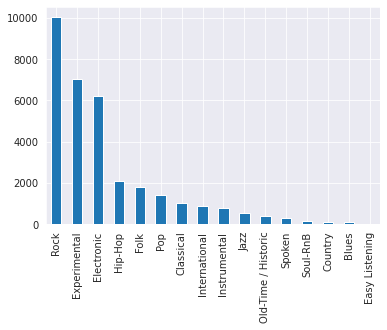

In [24]:
value_counts = track_genres.value_counts()
print(value_counts)
value_counts.plot.bar()

In [25]:
# genres dictionary
genres = {}
index = 0
for i in track_genres.unique():
    genres[i] = index
    index += 1
print(genres)

{'Hip-Hop': 0, 'Pop': 1, 'Rock': 2, 'Experimental': 3, 'Folk': 4, 'Jazz': 5, 'Electronic': 6, 'Spoken': 7, 'International': 8, 'Soul-RnB': 9, 'Blues': 10, 'Country': 11, 'Classical': 12, 'Old-Time / Historic': 13, 'Instrumental': 14, 'Easy Listening': 15}


In [26]:
print(len(track_genres))
print(len(features_df))
features_df.isna().any()
features_df

32823
32823


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
134           0.918445  0.674147  0.577818  1.281117  0.933746  0.078177   
...                ...       ...       ...       ...       ...       ...   
95823        -0.555692 -0.338323  0.883295  0.424315  1.450894  0.070183   
95831        -0.612445  0.702932  0.776201  0.186624  0.580003  0.287438   
95866         3.528371  4.667782  5.247205  4.168351  3.276534  4.309053   
95868        -0.033556  0.271865  0.280602  0.560396  1.511805  0.710866   
95871         5.215266  4.964749  0.824476  1.733783  2.557416  3.057908   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
134         1.199204 -0.175223  0.925482  1.438509  ...  0.058766  0.016322   
...              ...       ...       ...       ...  ...       ...       ...   
95823       0.716997  0.757623  0.300295  0.063043  ...  0.064474  0.012939   
95831      -0.037945 -1.151037 -1.074581  0.307664  ...  0.072024  0.011513   
95866       2.768949  3.115098  3.815794  3.940277  ...  0.031871  0.012202   
95868       1.451442  0.742910  0.739932  0.844851  ...  0.055034  0.012744   
95871       1.768616  3.665696  1.518494  1.523711  ...  0.058086  0.016176   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
134         0.015819   4.731087  0.419434  0.064370  0.050781  0.000000   
...              ...        ...       ...       ...       ...       ...   
95823       0.013397   6.294609  0.230469  0.039246  0.032715  0.004883   
95831       0.013774  -0.943706  0.441406  0.117571  0.106934  0.005371   
95866       0.012386   1.357928  0.400391  0.135901  0.143066  0.000000   
95868       0.013205  -0.223611  0.402344  0.173291  0.182617  0.000000   
95871       0.013788   0.166801  0.561035  0.211801  0.218262  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
134         1.806106  0.054623  
...              ...       ...  
95823       1.909812  0.026319  
95831       0.452720  0.085089  
95866      -0.795436  0.055681  
95868      -0.706943  0.048163  
95871      -0.058994  0.087301  

[32823 rows x 518 columns]

In [27]:
# generate train and test set

X_train, X_test, y_train, y_test = train_test_split(features_df.iloc[:8000], track_genres.iloc[:8000], test_size=0.4, random_state=42, stratify=track_genres.iloc[:8000])
# X_train, X_test, y_train, y_test = train_test_split(features_df, track_genres, test_size=0.4, random_state=42, stratify=track_genres)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

In [28]:
def evaluate_classifier(x_tr, x_te, y_tr, y_te, model):
    model.fit(x_tr, y_tr)
    prediction = model.predict(x_te)
    print(prediction[:10])
    print(y_te[:10])
    proba_train = model.predict_proba(x_te)
    # pd.DataFrame(proba_train, columns=list(np.unique(lab_encoder.inverse_transform(y_train))))
    print(pd.DataFrame(proba_train))
    print(classification_report(y_te, prediction))

<h1>PCA</h1>

In [29]:
from sklearn.decomposition import PCA

def pca_data(train_set, test_set, n_components, to_scale=True):

    if to_scale:
        # scale x_data
        data_scaler = StandardScaler()
        data_scaler.fit(train_set)

        train_set = data_scaler.transform(train_set)
        test_set = data_scaler.transform(test_set)

    # PCA
    pca = PCA(n_components = n_components)
    pca.fit(train_set)

    train_set = pca.transform(train_set)
    test_set = pca.transform(test_set)

    return train_set, test_set

In [30]:
# PCA test
x_data, x_test,_,_ = train_test_split(features_df.iloc[:8000], track_genres.iloc[:8000], test_size=0.4, random_state=42, stratify=track_genres.iloc[:8000])

# already scaled
x, y = pca_data(X_train, X_test, 2)
print(x)
print(y)

# to scale
x, y = pca_data(x_data, x_test, 2, to_scale=True)
print(x)
print(y)

[[  2.60354791  -0.58995119]
 [  4.40287103  -4.76999404]
 [ 10.45776958  17.50262319]
 ...
 [  4.34920137   0.47933985]
 [ -6.16308081  -9.56565025]
 [-18.17963718   5.65331263]]
[[16.14085012  4.24116619]
 [-3.3647734  -3.46883393]
 [-9.18277    -9.81920198]
 ...
 [ 3.71246594  6.02444555]
 [ 2.56445225  0.46266584]
 [-1.83267166 -2.24538347]]
[[  2.6035483   -0.58996835]
 [  4.40287072  -4.76996905]
 [ 10.45777044  17.50250499]
 ...
 [  4.34920135   0.47935106]
 [ -6.16308102  -9.56561957]
 [-18.1796375    5.65333079]]
[[16.14085019  4.24116482]
 [-3.36477334 -3.46883368]
 [-9.18277001 -9.81920519]
 ...
 [ 3.71246608  6.0244212 ]
 [ 2.56445245  0.4626638 ]
 [-1.83267153 -2.24539663]]


<h1>Model parametes tuning</h1>

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV


def optimize_model(model, x_train, y_train, parameters, to_scale=False):
    if to_scale:
        x_train = StandardScaler().fit_transform(x_train)

    #rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    #n_jobs=-1 use ll processors in parallel
    gs = GridSearchCV(model, parameters, scoring='f1_micro', cv=2, return_train_score=True, n_jobs=-1, verbose=10)

    gs.fit(x_train, y_train)

    print("best parameters: ", gs.best_params_)
    print("score: ", gs.best_score_)
    return gs.best_estimator_



<h1>SVM</h1>

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
print("Without PCA")
evaluate_classifier(X_train, X_test, y_train, y_test, svm_model)

pca_svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
print("With PCA")
pca_train, pca_test = pca_data(X_train, X_test, 2)
print(pca_train, pca_test)
evaluate_classifier(pca_train, pca_test, y_train, y_test, pca_svm_model)

In [ ]:
# SVM model evaluation
param_evaluated = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}

svm_base_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm_best_model = optimize_model(svm_base_model, X_train, y_train, param_evaluated)
evaluate_classifier(X_train, X_test, y_train, y_test,svm_best_model)
svm_best_model

# After run
# best parameters:  {'C': 100, 'gamma': 0.001}
# score:  0.66625

<h1>K-nearest neighbors</h1>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_classifier(X_train, X_test, y_train, y_test, knn_model)

In [ ]:
# KNN model evaluation
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]
param_evaluated = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_base_model = KNeighborsClassifier()
knn_best_model = optimize_model(knn_base_model, X_train, y_train, param_evaluated)
evaluate_classifier(X_train, X_test, y_train, y_test, knn_best_model)
knn_best_model

# After run
# best parameters:  {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
# score:  0.5852083333333333

<h1>Random forest</h1>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
evaluate_classifier(X_train, X_test, y_train, y_test, rf_model)

In [ ]:
# random forest model evaluation
n_estimators = list(range(90, 101))

param_evaluated = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': n_estimators}

"""param_evaluated = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}"""

rf_base_model = RandomForestClassifier()
rf_best_model = optimize_model(rf_base_model, X_train, y_train, param_evaluated)
evaluate_classifier(X_train, X_test, y_train, y_test, rf_best_model)
rf_best_model

<h1>Naive bayes</h1>

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
evaluate_classifier(X_train, X_test, y_train, y_test, nb_model)

In [ ]:
# naive bayes model evaluation
param_evaluated = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

nb_base_model = GaussianNB()
nb_best_model = optimize_model(nb_base_model, X_train, y_train, param_evaluated)
evaluate_classifier(X_train, X_test, y_train, y_test, nb_best_model)
nb_best_model

# After run
# best parameters:  {'var_smoothing': 0.01}
#score:  0.3989583333333333

<h1>Neural network</h1>

In [ ]:
# Split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features_df, track_genres, train_size=0.8, random_state=42, stratify=track_genres)

# Split remaining dataset in test and validation
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(f"Training has {len(X_train), len(y_train)}, Validation has {len(X_valid), len(y_valid)}, Testing has {len(X_test), len(y_test)}")

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_valid = lab_encoder.transform(y_valid)
y_test = lab_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

In [ ]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(518,)))
model.add(Dense(128, activation='relu'))
print(len(y_train[1]))
model.add(Dense(len(y_train[1]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, callbacks=[early_stop, PlotLossesKeras()])

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(518,)))
model.add(Dense(128, activation='relu'))
print(len(y_train[1]))
model.add(Dense(len(y_train[1]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, callbacks=[early_stop, PlotLossesKeras()])

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
def model_builder(hp):
    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(Dense(hp_units1, activation='relu', input_shape=(518,)))
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(Dense(hp_units2, activation='relu'))

    model.add(Dense(len(y_train[1]), activation='softmax'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_valid, y_valid), callbacks=[PlotLossesKeras()])

In [ ]:
hypermodel.evaluate(X_test, y_test)